In [5]:
## Suppress warnings for a cleaner output
import warnings
warnings.filterwarnings('ignore')
# Core libraries for data processing and mathematical operations
import matplotlib.pyplot as plt
import numpy as np
# Deep learning libraries
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import VGG16
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D,BatchNormalization  # Layers for model customization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import cv2
import os
import re
#import tensorflow_datasets as tfds

from PIL import Image

In [6]:
# Charger l'image

image_path = 'C:/Users/hedit/Desktop/Deep_Learning/Last_version/Mask_RCNN/NWPU VHR-10_dataset_coco/positive image set/001.jpg'
image = cv2.imread(image_path)

# Convertir l'image en niveaux de gris
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Appliquer un seuillage pour binariser l'image
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Trouver les contours dans l'image binarisée
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dessiner les boîtes englobantes des contours trouvés
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Afficher l'image avec les boîtes englobantes
plt.imshow(image)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


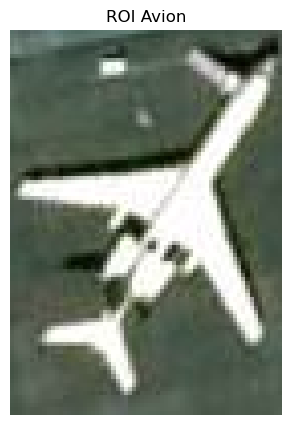

In [3]:
# Fonction pour extraire la région d'intérêt (ROI) de chaque boîte englobante
def extract_roi(image, coord1, coord2):
    x1, y1 = coord1
    x2, y2 = coord2
    roi = image[y1:y2, x1:x2]  # Extraction de la région d'intérêt (ROI)
    return roi

# Charger l'image d'origine
image_path = 'C:/Users/hedit/Desktop/Deep_Learning/Last_version/Mask_RCNN/NWPU VHR-10_dataset_coco/positive image set/001.jpg'
image = cv2.imread(image_path)


# Coordonnées de la région d'intérêt (xmin, ymin, xmax, ymax) pour l'avion
coord1 = (563, 478)
coord2 = (630, 573)

# Configuration de la figure Matplotlib pour afficher la ROI de l'avion
fig, ax = plt.subplots(1, 1, figsize=(5, 5))  # Créer la figure et l'axe


# Extraire la ROI de l'avion et l'afficher dans la figure
roi = extract_roi(image,coord1, coord2)
ax.imshow(roi)  # Afficher la ROI dans l'axe correspondant
ax.axis('off')  # Désactiver les axes pour une meilleure présentation
ax.set_title('ROI Avion')  # Ajouter un titre à la ROI de l'avion

plt.show()  # Afficher la figure avec la ROI de l'avion

In [4]:
# Chemin vers le dossier contenant les images et les fichiers de ground truth
images_folder = 'C:/Users/hedit/Desktop/Deep_Learning/Last_version/Mask_RCNN/NWPU VHR-10_dataset_coco/positive image set/001.jpg'
ground_truth_folder = 'C:/Users/hedit/Desktop/Deep_Learning/Last_version/Mask_RCNN/NWPU VHR-10_dataset_coco/ground truth'

# Dossier de sortie pour les objets extraits
output_folder = 'C:/Users/hedit/Desktop/Deep_Learning/Last_version/Mask_RCNN/NWPU VHR-10_dataset_coco/objets_extraits'
os.makedirs(output_folder, exist_ok=True)

# Parcourir les fichiers de ground truth et extraire les objets
for gt_file in os.listdir(ground_truth_folder):
    # Lire chaque fichier de ground truth
    with open(os.path.join(ground_truth_folder, gt_file), 'r') as file:
        lines = file.readlines()
    
    # Charger l'image correspondante
    image_name = os.path.splitext(gt_file)[0] + '.jpg'
    image_path = os.path.join(images_folder, image_name)
    image = cv2.imread(image_path)
    
    # Parcourir les lignes du fichier de ground truth
    for line in lines:
        data = line.strip().split(',')
        if len(data) == 5:
            # Supprimer les caractères non numériques et convertir en entiers
            coordinates = [int(coord.strip('()')) for coord in data[:4]]
            label = int(data[4])  # Convertir le label en entier
            
            # Extraire l'objet de l'image
            x1, y1, x2, y2 = coordinates
            # Extraire l'objet de l'image
            object_roi = image[y1:y2, x1:x2]
            # Enregistrer l'objet extrait avec le label correspondant
            output_filename = f'{label}_{image_name}'
            output_path = os.path.join(output_folder, output_filename)
            cv2.imwrite(output_path, object_roi)

TypeError: 'NoneType' object is not subscriptable

In [6]:
# Chemin vers le dossier contenant les objets extraits
extracted_objects_folder = 'C:/Users/hedit/Desktop/Deep_Learning/Principal_Project/NWPU VHR-10 dataset/objets_extraits'

# Listes pour stocker les chemins des images et leurs labels
image_paths_Fin = []
labelsFin = []

# Parcourir les fichiers dans le dossier des objets extraits
for filename in os.listdir(extracted_objects_folder):
    if filename.endswith('.jpg'):
        # Extraire le label à partir du nom du fichier
        label = int(filename.split('_')[0])
        labelsFin.append(label)
        
        # Chemin complet de l'image
        image_path = os.path.join(extracted_objects_folder, filename)
        image_paths_Fin.append(image_path)

# Convertir les listes en tableaux NumPy pour une manipulation plus facile
image_paths_Fin = np.array(image_paths_Fin)
labelsFin = np.array(labelsFin)

# # Diviser les données en ensembles d'entraînement et de test (80% pour l'entraînement, 20% pour le test)
# x_train, x_test, y_train, y_test = train_test_split(image_paths_Fin, labelsFin, test_size=0.3, random_state=42)


# Diviser les données en ensembles d'entraînement, de validation et de test (70% pour l'entraînement, 20% pour la validation, 10% pour le test)
x_train, x_val_test, y_train, y_val_test = train_test_split(image_paths_Fin, labelsFin, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=1/3, random_state=42)  # Diviser le reste en val et test

# Afficher le nombre d'échantillons dans chaque ensemble
print(f'Nombre d\'échantillons total : {len(image_paths_Fin)}')
print(f'Nombre d\'échantillons dans l\'ensemble d\'entraînement : {len(x_train)}')
print(f'Nombre d\'échantillons dans l\'ensemble de validation : {len(x_val)}')
print(f'Nombre d\'échantillons dans l\'ensemble de test : {len(x_test)}')

Nombre d'échantillons total : 888
Nombre d'échantillons dans l'ensemble d'entraînement : 621
Nombre d'échantillons dans l'ensemble de validation : 178
Nombre d'échantillons dans l'ensemble de test : 89


In [5]:
x_train

array(['C:/Users/hedit/Desktop/Deep_Learning/Principal_Project/NWPU VHR-10 dataset/objets_extraits\\5_338.jpg',
       'C:/Users/hedit/Desktop/Deep_Learning/Principal_Project/NWPU VHR-10 dataset/objets_extraits\\4_112.jpg',
       'C:/Users/hedit/Desktop/Deep_Learning/Principal_Project/NWPU VHR-10 dataset/objets_extraits\\1_521.jpg',
       'C:/Users/hedit/Desktop/Deep_Learning/Principal_Project/NWPU VHR-10 dataset/objets_extraits\\5_148.jpg',
       'C:/Users/hedit/Desktop/Deep_Learning/Principal_Project/NWPU VHR-10 dataset/objets_extraits\\4_480.jpg',
       'C:/Users/hedit/Desktop/Deep_Learning/Principal_Project/NWPU VHR-10 dataset/objets_extraits\\4_252.jpg',
       'C:/Users/hedit/Desktop/Deep_Learning/Principal_Project/NWPU VHR-10 dataset/objets_extraits\\8_271.jpg',
       'C:/Users/hedit/Desktop/Deep_Learning/Principal_Project/NWPU VHR-10 dataset/objets_extraits\\1_005.jpg',
       'C:/Users/hedit/Desktop/Deep_Learning/Principal_Project/NWPU VHR-10 dataset/objets_extraits\\9_17

In [6]:
y_train

array([ 5,  4,  1,  5,  4,  4,  8,  1,  9,  2,  5,  7, 10,  1,  4,  7,  1,
        1, 10,  5,  2,  5,  7,  9,  4,  1,  1, 10,  6,  5, 10,  7,  4,  7,
        1,  3,  2,  5,  4,  1,  8,  4,  2, 10,  6,  1,  4, 10,  4,  4,  5,
       10,  4,  4,  4, 10,  7,  8,  6,  4,  9,  6,  4,  4, 10,  7,  4, 10,
       10,  4,  4,  4,  7, 10,  2,  4,  6,  2,  5,  6,  4,  7,  5,  5,  2,
        6,  5,  1,  3,  6,  7, 10,  1,  6,  5,  1,  1,  4,  1,  6,  1,  4,
        9,  8,  9,  5,  7,  1, 10,  4, 10, 10,  4,  1,  7,  5,  7,  9,  2,
        6,  9,  6,  2,  6,  7,  6,  4,  3,  4,  4,  6, 10, 10,  7,  3,  5,
        6,  9,  4,  2,  5,  5,  6,  4,  5, 10,  3, 10,  4,  2,  6,  7,  9,
        5,  4,  7,  5,  2,  3,  1,  5,  5,  6,  4,  2,  7,  5,  1, 10,  7,
        6,  4, 10,  7,  2,  4,  7,  7,  3,  1,  7,  1,  1,  8,  4,  3, 10,
        9,  9,  7,  4,  5,  1,  4,  7,  1,  2,  6,  7,  8,  9,  4,  4,  6,
        1,  7,  7,  8,  7,  4,  4,  6,  4,  4,  4,  4, 10,  4,  4,  5,  7,
        4,  2,  9,  7,  1

In [7]:
def preprocess_data(images):
    processed_images = []
    for image in images:
        # Redimensionner l'image à la taille spécifique (par exemple, 224x224)
        resized_image = cv2.resize(image, (224, 224))
        # Normaliser les valeurs de pixel dans la plage [0, 1]
        normalized_image = resized_image.astype(np.float32) / 255.0
        processed_images.append(normalized_image)
    return np.array(processed_images)

In [8]:
# Définir la taille cible des images redimensionnées
target_size = (224, 224)  # Par exemple, 224x224 pixels

# Fonction pour charger et redimensionner une image
def load_and_resize_image(image_path):
    # Charger l'image depuis le chemin spécifié
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Décodez l'image en RGB

    # Redimensionner l'image à la taille cible
    image = tf.image.resize(image, target_size)

    return image

In [9]:
resized_images = [load_and_resize_image(image) for image in x_train]
resized_images_test = [load_and_resize_image(image) for image in x_test]
resized_images_val = [load_and_resize_image(image) for image in x_val_test]

In [10]:
# Convertir les listes en Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((resized_images, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((resized_images_test, y_test))
val_dataset = tf.data.Dataset.from_tensor_slices((resized_images_val, y_val_test))

In [11]:
def load_and_preprocess_image(file_path):
    # Charger l'image en niveaux de gris
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    # Redimensionner l'image à la taille spécifique (par exemple, 224x224)
    resized_image = cv2.resize(image, (224, 224))
    # Convertir les valeurs de pixel en type float et normaliser
    preprocessed_image = resized_image.astype(np.float32) / 255.0
    return preprocessed_image

# Charger et prétraiter toutes les images d'entraînement et de test
x_train_preprocessed = np.array([load_and_preprocess_image(file_path) for file_path in x_train])
x_test_preprocessed = np.array([load_and_preprocess_image(file_path) for file_path in x_test])

In [12]:
# Define image dimensions and batch size
IMG_SIZE = 224
channels = 3
BATCH_SIZE = 32

def augment(image, label):
    image = tf.image.random_brightness(image, max_delta=0.5)  # A max_delta of 0.5 means that the brightness will be randomly adjusted by a value between -0.5 and 0.5
    image = tf.image.flip_left_right(image)
    image = tf.image.rot90(image)
    return image, label

def format_images(image, label):
    image = tf.cast(image, tf.float32) #convert the pixel values of the image to floating-point format.
    image = (image/255) - 1  #NORMALIZATION
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    return image, label

In [13]:
train_ds = train_dataset.map(format_images)
validation_batches = val_dataset.map(format_images).batch(BATCH_SIZE)
test_batches = test_dataset.map(format_images).batch(BATCH_SIZE)

In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


modelCNN=keras.Sequential()

modelCNN.add(Conv2D(16,3,activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels),kernel_regularizer=l2(0.001)))
modelCNN.add(BatchNormalization())
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Dropout(0.2))

modelCNN.add(Conv2D(32, 3, activation='relu',kernel_regularizer=l2(0.001)))
modelCNN.add(BatchNormalization())
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Dropout(0.25))

modelCNN.add(Flatten())

modelCNN.add(Dense(128, activation='relu'))
modelCNN.add(BatchNormalization())
modelCNN.add(Dense(64, activation='relu'))
modelCNN.add(BatchNormalization())
modelCNN.add(Dense(11, activation='softmax'))

# Compiler le modèle avec l'optimiseur Adam
optimizer = Adam(learning_rate=0.001)

modelCNN.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

modelCNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 93312)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,944,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,959,083 (45.62 MB)

 Trainable params: 11,958,603 (45.62 MB)

 Non-trainable params: 480 (1.88 KB)

In [14]:
SHUFFLE_BUFFER_SIZE = 3000
AUTOTUNE = tf.data.AUTOTUNE 

train_batches = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

In [27]:
epochs=10

historyCNN = modelCNN.fit(
  train_batches,
  validation_data=validation_batches,
  epochs=epochs
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 659ms/step - accuracy: 0.2492 - loss: 2.3663 - val_accuracy: 0.1049 - val_loss: 2.3068
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 634ms/step - accuracy: 0.5228 - loss: 1.5627 - val_accuracy: 0.0861 - val_loss: 2.4870
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 593ms/step - accuracy: 0.6146 - loss: 1.2065 - val_accuracy: 0.1948 - val_loss: 2.4397
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 608ms/step - accuracy: 0.7095 - loss: 0.9853 - val_accuracy: 0.0936 - val_loss: 2.7202
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 610ms/step - accuracy: 0.7495 - loss: 0.8632 - val_accuracy: 0.1049 - val_loss: 2.7977
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 608ms/step - accuracy: 0.8149 - loss: 0.6998 - val_accuracy: 0.1049 - val_loss: 2.7964
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 591ms/step - accuracy: 0.8431 - loss: 0.5632 - val_accuracy: 0.1236 - val_loss: 2.9251
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 624ms/step - accuracy: 0.8747 - loss: 0.4841 - val_accu

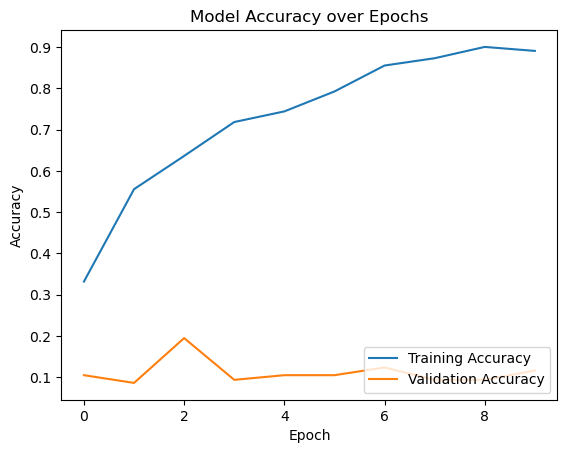

In [28]:
# Visualize model training and validation accuracy
plt.plot(historyCNN.history['accuracy'], label='Training Accuracy')
plt.plot(historyCNN.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy over Epochs')
plt.show()

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.regularizers import l2

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - accuracy: 0.1325 - loss: 3.0109 - val_accuracy: 0.1000 - val_loss: 2.9142
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.0954 - loss: 3.1132 - val_accuracy: 0.1000 - val_loss: 2.7171
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.1294 - loss: 2.7205 - val_accuracy: 0.1000 - val_loss: 2.4961
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.1322 - loss: 2.7371 - val_accuracy: 0.0000e+00 - val_loss: 3.0549
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.1755 - loss: 2.4366 - val_accuracy: 0.0500 - val_loss: 2.8736
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step - accuracy: 0.0768 - loss: 3.0139 - val_accuracy: 0.1000 - val_loss: 13.5110
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.7889 - loss: 0.8096 - val_accuracy: 0.1000 - val_loss: 6.9798
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.9428 - loss: 0.554

[]

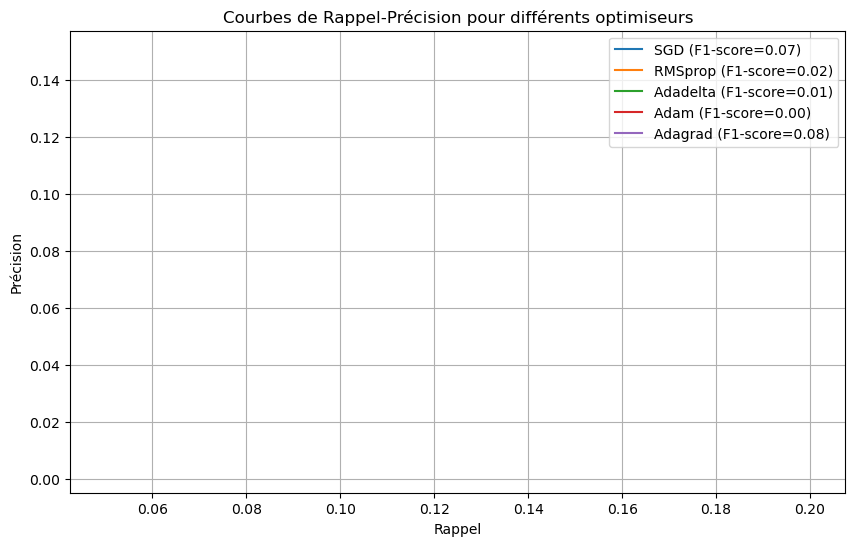

In [30]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adadelta, Adam, Adagrad
from sklearn.metrics import precision_recall_fscore_support

# Définir les optimiseurs à tester
optimizers = {
    'SGD': SGD(learning_rate=0.001),
    'RMSprop': RMSprop(learning_rate=0.001),
    'Adadelta': Adadelta(learning_rate=0.001),
    'Adam': Adam(learning_rate=0.001),
    'Adagrad': Adagrad(learning_rate=0.001),
}

# Fonction pour construire le modèle avec un optimiseur spécifique
def build_model(optimizer):
    model = keras.Sequential([
        Conv2D(16, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, channels), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        Conv2D(32, 3, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(11, activation='softmax')
    ])
    # Compiler le modèle avec l'optimiseur spécifique
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Construire, entraîner et évaluer chaque modèle avec un optimiseur différent
models = {}
results = {}

# Données factices pour illustrer
IMG_SIZE = 128
channels = 3
x_train, y_train = np.random.randn(100, IMG_SIZE, IMG_SIZE, channels), np.random.randint(0, 11, 100)
x_val, y_val = np.random.randn(20, IMG_SIZE, IMG_SIZE, channels), np.random.randint(0, 11, 20)


for optimizer_name, optimizer in optimizers.items():
    model = build_model(optimizer)
    model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_val, y_val))
    models[optimizer_name] = model
    y_pred = model.predict(x_val)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, np.argmax(y_pred, axis=1), average='weighted')
    results[optimizer_name] = {'precision': precision, 'recall': recall, 'f1_score': f1_score}

# Dessiner les courbes de rappel-précision pour chaque modèle
plt.figure(figsize=(10, 6))
for optimizer_name, result in results.items():
    plt.plot(result['recall'], result['precision'], label=f'{optimizer_name} (F1-score={result["f1_score"]:.2f})')

plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbes de Rappel-Précision pour différents optimiseurs')
plt.legend()
plt.grid(True)
plt.plot()


In [31]:
 results

{'SGD': {'precision': 0.15, 'recall': 0.05, 'f1_score': 0.075},
 'RMSprop': {'precision': 0.01,
  'recall': 0.1,
  'f1_score': 0.01818181818181818},
 'Adadelta': {'precision': 0.0029411764705882353,
  'recall': 0.05,
  'f1_score': 0.005555555555555555},
 'Adam': {'precision': 0.0025,
  'recall': 0.05,
  'f1_score': 0.0047619047619047615},
 'Adagrad': {'precision': 0.05, 'recall': 0.2, 'f1_score': 0.08}}

In [32]:
# Extraire les valeurs pour l'optimiseur "SGD"
sgd_values = results['SGD']

# Transformer les valeurs en liste
sgd_list = [sgd_values['precision'], sgd_values['recall'], sgd_values['f1_score']]

print(sgd_list)  # Affiche la liste des valeurs associées à l'optimiseur "SGD"



[0.15, 0.05, 0.075]


In [33]:
# Extraire toutes les valeurs de précision
precision_values = [results[key]['precision'] for key in results]

print(precision_values)  # Affiche la liste des valeurs de précision pour chaque optimiseur




[0.15, 0.01, 0.0029411764705882353, 0.0025, 0.05]


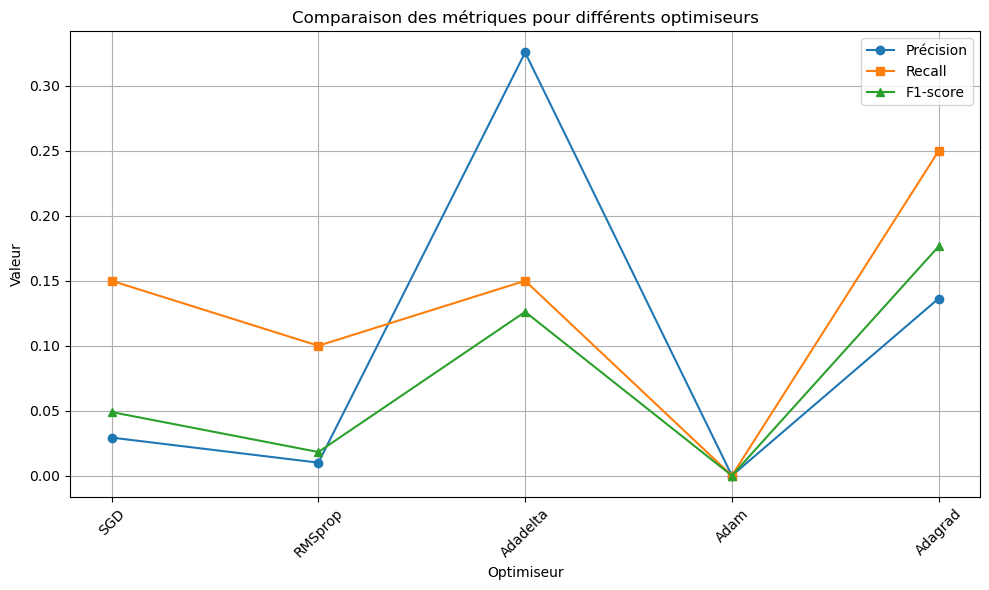

In [34]:
from matplotlib import pyplot as plt

# Récupérer les données du dictionnaire
optimizers = ['SGD', 'RMSprop', 'Adadelta', 'Adam', 'Adagrad']
precision_values = [0.029292929292929294, 0.01, 0.32575757575757575, 0.0, 0.13636363636363635]
recall_values = [0.15, 0.1, 0.15, 0.0, 0.25]
f1_scores = [0.048951048951048945, 0.01818181818181818, 0.1260989010989011, 0.0, 0.1764705882352941]

# Plotter les valeurs de précision, rappel et f1-score pour chaque optimiseur
plt.figure(figsize=(10, 6))

# Précision
plt.plot(optimizers, precision_values, marker='o', label='Précision')

# Rappel
plt.plot(optimizers, recall_values, marker='s', label='Recall')

# F1-score
plt.plot(optimizers, f1_scores, marker='^', label='F1-score')

# Ajouter des étiquettes et une légende
plt.xlabel('Optimiseur')
plt.ylabel('Valeur')
plt.title('Comparaison des métriques pour différents optimiseurs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Afficher le graphique
plt.show()


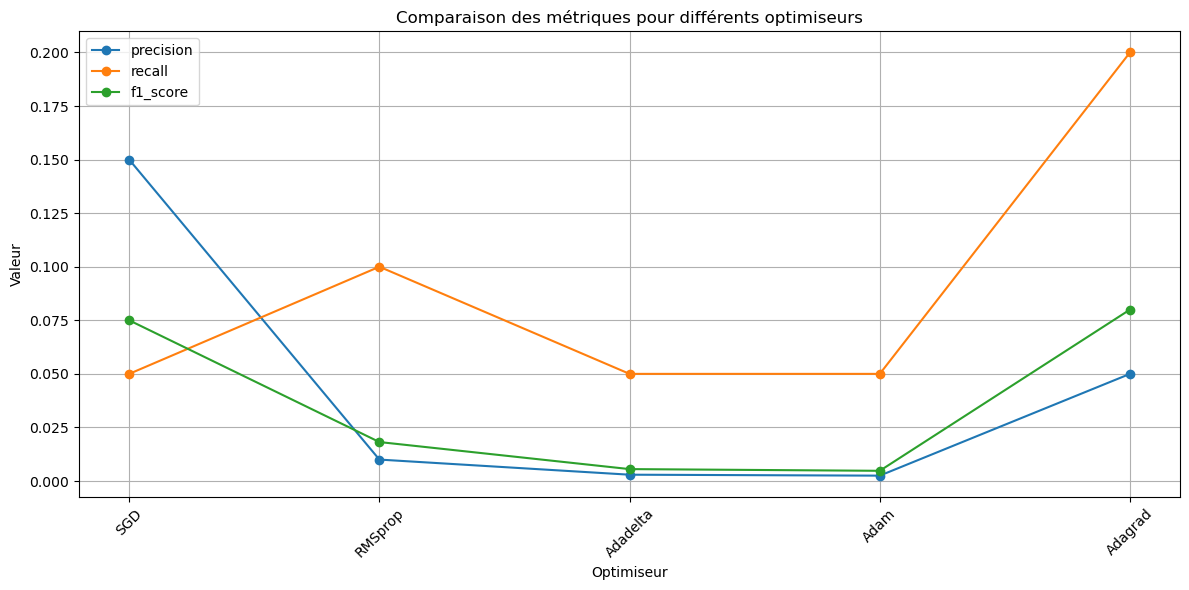

In [16]:
#Train Airplane
train_ds_filtered_airplane = train_dataset.filter(lambda image, label: label == 1)

train_ds_filtered_airplane = train_ds_filtered_airplane.map(format_images)

train_batches_filtered_airplane = train_ds_filtered_airplane.batch(BATCH_SIZE)
#Validation Airplane
validation_ds_filtered_airplane = val_dataset.filter(lambda image, label: label == 1)

validation_ds_filtered_airplane = validation_ds_filtered_airplane.map(format_images)

validation_ds_filtered_airplane = validation_ds_filtered_airplane.batch(BATCH_SIZE)

#Test Airplane
test_ds_filtered_airplane = test_dataset.filter(lambda image, label: label == 1)

test_ds_filtered_airplane = test_ds_filtered_airplane.map(format_images)

test_ds_filtered_airplane = test_ds_filtered_airplane.batch(BATCH_SIZE)

In [17]:
#Train Ship
train_ds_filtered_ship= train_dataset.filter(lambda image, label: label == 2)

train_ds_filtered_ship = train_ds_filtered_ship.map(format_images)

train_batches_filtered_ship = train_ds_filtered_ship.batch(BATCH_SIZE)
#Validation Ship
validation_ds_filtered_ship = val_dataset.filter(lambda image, label: label == 2)

validation_ds_filtered_ship = validation_ds_filtered_ship.map(format_images)

validation_ds_filtered_ship = validation_ds_filtered_ship.batch(BATCH_SIZE)

#Test Ship
test_ds_filtered_ship = test_dataset.filter(lambda image, label: label ==2)

test_ds_filtered_ship = test_ds_filtered_ship.map(format_images)

test_ds_filtered_ship = test_ds_filtered_ship.batch(BATCH_SIZE)

In [18]:
#Train storage tank
train_ds_filtered_storage= train_dataset.filter(lambda image, label: label == 3)

train_ds_filtered_storage = train_ds_filtered_storage.map(format_images)

train_batches_filtered_storage = train_ds_filtered_storage.batch(BATCH_SIZE)
#Validation storage tank
validation_ds_filtered_storage = val_dataset.filter(lambda image, label: label == 3)

validation_ds_filtered_storage = validation_ds_filtered_storage.map(format_images)

validation_ds_filtered_storage = validation_ds_filtered_storage.batch(BATCH_SIZE)

#Test storage tank
test_ds_filtered_storage = test_dataset.filter(lambda image, label: label == 3)

test_ds_filtered_storage = test_ds_filtered_storage.map(format_images)

test_ds_filtered_storage = test_ds_filtered_storage.batch(BATCH_SIZE)
#Train baseball
train_ds_filtered_baseball= train_dataset.filter(lambda image, label: label == 4)

train_ds_filtered_baseball = train_ds_filtered_baseball.map(format_images)

train_batches_filtered_baseball = train_ds_filtered_baseball.batch(BATCH_SIZE)
#Validation baseball
validation_ds_filtered_baseball = val_dataset.filter(lambda image, label: label == 4)

validation_ds_filtered_baseball = validation_ds_filtered_baseball.map(format_images)

validation_ds_filtered_baseball = validation_ds_filtered_baseball.batch(BATCH_SIZE)

#Test baseball
test_ds_filtered_baseball = test_dataset.filter(lambda image, label: label == 4)

test_ds_filtered_baseball = test_ds_filtered_baseball.map(format_images)

test_ds_filtered_baseball = test_ds_filtered_baseball.batch(BATCH_SIZE)
#Train tennis
train_ds_filtered_tennis= train_dataset.filter(lambda image, label: label == 5)

train_ds_filtered_tennis = train_ds_filtered_tennis.map(format_images)

train_batches_filtered_tennis = train_ds_filtered_tennis.batch(BATCH_SIZE)

#Validation baseball
validation_ds_filtered_tennis= val_dataset.filter(lambda image, label: label == 5)

validation_ds_filtered_tennis = validation_ds_filtered_tennis.map(format_images)

validation_ds_filtered_tennis = validation_ds_filtered_tennis.batch(BATCH_SIZE)

#Test baseball
test_ds_filtered_tennis = test_dataset.filter(lambda image, label: label == 5)

test_ds_filtered_tennis = test_ds_filtered_tennis.map(format_images)

test_ds_filtered_tennis = test_ds_filtered_tennis.batch(BATCH_SIZE)
#Train basketball
train_ds_filtered_basketball= train_dataset.filter(lambda image, label: label == 6)

train_ds_filtered_basketball = train_ds_filtered_basketball.map(format_images)

train_batches_filtered_basketball = train_ds_filtered_basketball.batch(BATCH_SIZE)
#Validation basketball
validation_ds_filtered_basketball= val_dataset.filter(lambda image, label: label == 6)

validation_ds_filtered_basketball = validation_ds_filtered_basketball.map(format_images)

validation_ds_filtered_basketball = validation_ds_filtered_basketball.batch(BATCH_SIZE)

#Test basketball
test_ds_filtered_basketball = test_dataset.filter(lambda image, label: label == 6)

test_ds_filtered_basketball = test_ds_filtered_basketball.map(format_images)

test_ds_filtered_basketball = test_ds_filtered_basketball.batch(BATCH_SIZE)


#Train ground
train_ds_filtered_ground= train_dataset.filter(lambda image, label: label == 7)

train_ds_filtered_ground = train_ds_filtered_ground.map(format_images)

train_batches_filtered_ground = train_ds_filtered_ground.batch(BATCH_SIZE)
#Validation ground
validation_ds_filtered_ground= val_dataset.filter(lambda image, label: label == 7)

validation_ds_filtered_ground = validation_ds_filtered_ground.map(format_images)

validation_ds_filtered_ground = validation_ds_filtered_ground.batch(BATCH_SIZE)

#Test ground
test_ds_filtered_ground = test_dataset.filter(lambda image, label: label == 7)

test_ds_filtered_ground = test_ds_filtered_ground.map(format_images)

test_ds_filtered_ground = test_ds_filtered_ground.batch(BATCH_SIZE)
#Train harbor
train_ds_filtered_harbor= train_dataset.filter(lambda image, label: label == 8)
train_ds_filtered_harbor = train_ds_filtered_harbor.map(format_images)

train_batches_filtered_harbor = train_ds_filtered_harbor.batch(BATCH_SIZE)
#Validation harbor
validation_ds_filtered_harbor= val_dataset.filter(lambda image, label: label == 8)

validation_ds_filtered_harbor = validation_ds_filtered_harbor.map(format_images)

validation_ds_filtered_harbor = validation_ds_filtered_harbor.batch(BATCH_SIZE)

#Test harbor
test_ds_filtered_harbor = test_dataset.filter(lambda image, label: label == 8)

test_ds_filtered_harbor = test_ds_filtered_harbor.map(format_images)

test_ds_filtered_harbor = test_ds_filtered_harbor.batch(BATCH_SIZE)
#Train bridge
train_ds_filtered_bridge= train_dataset.filter(lambda image, label: label == 9)
train_ds_filtered_bridge = train_ds_filtered_bridge.map(format_images)

train_batches_filtered_bridge = train_ds_filtered_bridge.batch(BATCH_SIZE)
#Validation bridge
validation_ds_filtered_bridge= val_dataset.filter(lambda image, label: label == 9)

validation_ds_filtered_bridge = validation_ds_filtered_bridge.map(format_images)

validation_ds_filtered_bridge = validation_ds_filtered_bridge.batch(BATCH_SIZE)

#Test bridge
test_ds_filtered_bridge= test_dataset.filter(lambda image, label: label == 9)

test_ds_filtered_bridge = test_ds_filtered_bridge.map(format_images)

test_ds_filtered_bridge = test_ds_filtered_bridge.batch(BATCH_SIZE)

#Train vehicle
train_ds_filtered_vehicle= train_dataset.filter(lambda image, label: label == 10)
train_ds_filtered_vehicle = train_ds_filtered_vehicle.map(format_images)

train_batches_filtered_vehicle = train_ds_filtered_vehicle.batch(BATCH_SIZE)
#Validation vehicle
validation_ds_filtered_vehicle= val_dataset.filter(lambda image, label: label == 10)

validation_ds_filtered_vehicle = validation_ds_filtered_vehicle.map(format_images)

validation_ds_filtered_vehicle = validation_ds_filtered_vehicle.batch(BATCH_SIZE)

#Test vehicle
test_ds_filtered_vehicle= test_dataset.filter(lambda image, label: label == 10)

test_ds_filtered_vehicle = test_ds_filtered_vehicle.map(format_images)

test_ds_filtered_vehicle = test_ds_filtered_vehicle.batch(BATCH_SIZE)

In [39]:
#Model Airplane Label =1

modelAirplane=keras.Sequential()

modelAirplane.add(Conv2D(16,3,activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels),kernel_regularizer=l2(0.001)))
modelAirplane.add(BatchNormalization())
modelAirplane.add(MaxPooling2D(pool_size=(2, 2)))
modelAirplane.add(Dropout(0.2))

modelAirplane.add(Conv2D(32, 3, activation='relu',kernel_regularizer=l2(0.001)))
modelAirplane.add(BatchNormalization())
modelAirplane.add(MaxPooling2D(pool_size=(2, 2)))
modelAirplane.add(Dropout(0.25))

modelAirplane.add(Flatten())

modelAirplane.add(Dense(128, activation='relu'))
modelAirplane.add(BatchNormalization())
modelAirplane.add(Dense(64, activation='relu'))
modelAirplane.add(BatchNormalization())
modelAirplane.add(Dense(11, activation='softmax'))

# Compiler le modèle avec l'optimiseur Adam
optimizer = Adam(learning_rate=0.001)

modelAirplane.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

modelAirplane.summary()


SHUFFLE_BUFFER_SIZE = 3000
AUTOTUNE = tf.data.AUTOTUNE 

train_batches_plane = train_ds_filtered_airplane.shuffle(SHUFFLE_BUFFER_SIZE).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

epochs=10

historyAirplane = modelAirplane.fit(
  train_batches_plane,
  validation_data=validation_ds_filtered_airplane,
  epochs=epochs
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 126, 126, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 61, 61, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │       3,686,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,701,547 (14.12 MB)

 Trainable params: 3,701,067 (14.12 MB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 451ms/step - accuracy: 0.0328 - loss: 2.9642 - val_accuracy: 0.4737 - val_loss: 1.0818
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.1337 - loss: 2.5826 - val_accuracy: 0.3684 - val_loss: 1.0917
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.0407 - loss: 2.4693 - val_accuracy: 0.1579 - val_loss: 1.1025
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.0219 - loss: 2.3469 - val_accuracy: 0.2632 - val_loss: 1.1283
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.1149 - loss: 2.2833 - val_accuracy: 0.1053 - val_loss: 1.1493
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.0923 - loss: 2.2412 - val_accuracy: 0.0000e+00 - val_loss: 1.1665
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.1587 - loss: 2.1816 - val_accuracy: 0.0000e+00 - val_loss: 1.1620
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.1744 - loss: 2.1312 - val_accuracy: 0.0526 - v

## Le model CNN souffre d'un overfitting meme si a on appliqué les différents techniques de régularisations telque : L2, Dropout , BatchNormalizer

## Pre-trained Model : VGG16

In [40]:
# Load the VGG16 model, pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
# Create a custom model on top of the pretrained VGG16 model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(11, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    train_batches,
    validation_data=validation_batches,
    epochs=10
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 75s 1us/step


Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,565,899 (105.16 MB)

 Trainable params: 12,851,211 (49.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 104s 5s/step - accuracy: 0.3093 - loss: 2.2671 - val_accuracy: 0.6180 - val_loss: 1.0927
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.7300 - loss: 0.8641 - val_accuracy: 0.7715 - val_loss: 0.7423
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.8325 - loss: 0.5782 - val_accuracy: 0.8539 - val_loss: 0.5758
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.8623 - loss: 0.4763 - val_accuracy: 0.8652 - val_loss: 0.4950
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.8997 - loss: 0.3419 - val_accuracy: 0.8951 - val_loss: 0.4638
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.9050 - loss: 0.3290 - val_accuracy: 0.8240 - val_loss: 0.4689
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.9269 - loss: 0.2781 - val_accuracy: 0.8202 - val_loss: 0.4443
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.9522 - loss: 0.2240 - val_accuracy: 0.8090 - val_loss

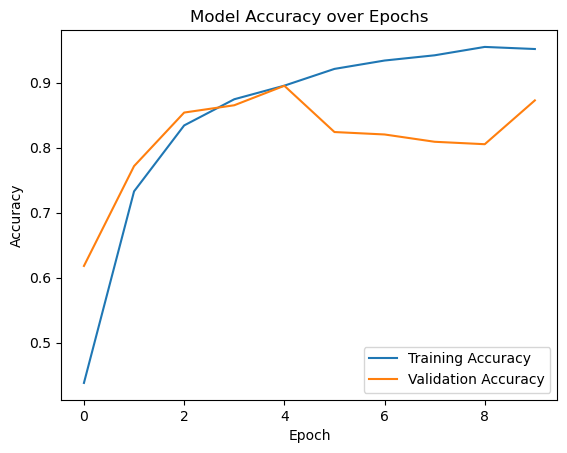

In [41]:
# Visualize model training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy over Epochs')
plt.show()

## Pre-trained Model : RES_NET 50

In [19]:
#REMARQUE : A ne pas excecuter (prend beaucoup de temps et de memoire !!!)

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2DTranspose, Conv2D, Dense
from tensorflow.keras.models import Model

# # Charger le modèle pré-entraîné (exemple avec ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# # Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(11, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


# # Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model.summary()
epochs=30

history = model.fit(
   train_batches,
   validation_data=validation_batches,
   epochs=epochs
 )

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 74,974,091 (286.00 MB)

 Trainable params: 51,386,379 (196.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.1239 - loss: 3.6465 - val_accuracy: 0.1086 - val_loss: 2.1197
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.1976 - loss: 2.2305 - val_accuracy: 0.3333 - val_loss: 2.0226
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.3098 - loss: 2.0509 - val_accuracy: 0.3858 - val_loss: 1.9693
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2768 - loss: 2.0449 - val_accuracy: 0.2959 - val_loss: 1.9658
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.2715 - loss: 2.0202 - val_accuracy: 0.2996 - val_loss: 1.9209
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.2445 - loss: 2.0301 - val_accuracy: 0.3371 - val_loss: 1.8911
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.2806 - loss: 1.9682 - val_accuracy: 0.3034 - val_loss: 1.8831
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.2915 - loss: 1.9427 - val_accuracy: 0.2959 - val_loss:

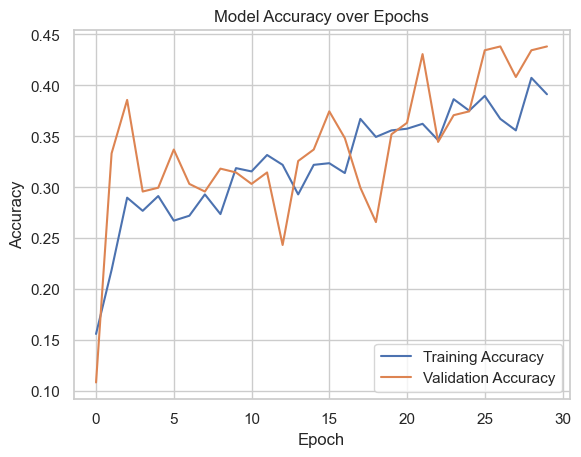

In [26]:
# Visualize model training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy over Epochs')
plt.show()

## Conclusion : VGG16 est meilleur que RESNET 50 meme dans la prediction il est trés précis comme model pré-entrainé

# YOLO V5

## Phase d'analyse de performance des modéles

## Affichage de nombre d'objets par leurs types 

In [20]:
##Dans le cas general
from collections import Counter

# Compter le nombre de chaque valeur
compteur = Counter(labelsFin)

# Afficher le résultat
print(compteur)

Counter({4: 176, 7: 163, 5: 108, 1: 90, 10: 86, 6: 86, 9: 67, 2: 57, 3: 28, 8: 27})


In [21]:
class_names = {
    1: 'airplane',
    2: 'ship',
    3: 'storage tank',
    4: 'baseball diamond',
    5: 'tennis court',
    6: 'basketball court',
    7: 'ground track field',
    8: 'harbor',
    9: 'bridge',
    10: 'vehicle'
}

In [22]:
# Résultat de Counter
counter_result = {4: 176, 7: 163, 5: 108, 1: 90, 10: 86, 6: 86, 9: 67, 2: 57, 3: 28, 8: 27}

# Transformer en dictionnaire
result_dict = {class_names[key]: value for key, value in counter_result.items()}

print(result_dict)

{'baseball diamond': 176, 'ground track field': 163, 'tennis court': 108, 'airplane': 90, 'vehicle': 86, 'basketball court': 86, 'bridge': 67, 'ship': 57, 'storage tank': 28, 'harbor': 27}


In [23]:
##Train , test 

# Compter le nombre de chaque valeur
compteurTrain = Counter(y_train)
# Compter le nombre de chaque valeur
compteurTest = Counter(y_test)

# Afficher le résultata
print(compteurTrain)
print(compteurTest)

Counter({4: 118, 7: 117, 1: 71, 5: 69, 6: 61, 10: 57, 9: 49, 2: 42, 3: 20, 8: 17})
Counter({4: 16, 7: 16, 5: 13, 10: 12, 2: 8, 6: 7, 1: 5, 8: 4, 3: 4, 9: 4})


In [24]:
counter_result_train={4: 118, 7: 117, 1: 71, 5: 69, 6: 61, 10: 57, 9: 49, 2: 42, 3: 20, 8: 17}
counter_result_test={4: 16, 7: 16, 5: 13, 10: 12, 2: 8, 6: 7, 1: 5, 8: 4, 3: 4, 9: 4}
# Transformer en dictionnaire
result_dict_train = {class_names[key]: value for key, value in counter_result_train.items()}
result_dict_test = {class_names[key]: value for key, value in counter_result_test.items()}

print(result_dict_train)
print(result_dict_test)

{'baseball diamond': 118, 'ground track field': 117, 'airplane': 71, 'tennis court': 69, 'basketball court': 61, 'vehicle': 57, 'bridge': 49, 'ship': 42, 'storage tank': 20, 'harbor': 17}
{'baseball diamond': 16, 'ground track field': 16, 'tennis court': 13, 'vehicle': 12, 'ship': 8, 'basketball court': 7, 'airplane': 5, 'harbor': 4, 'storage tank': 4, 'bridge': 4}


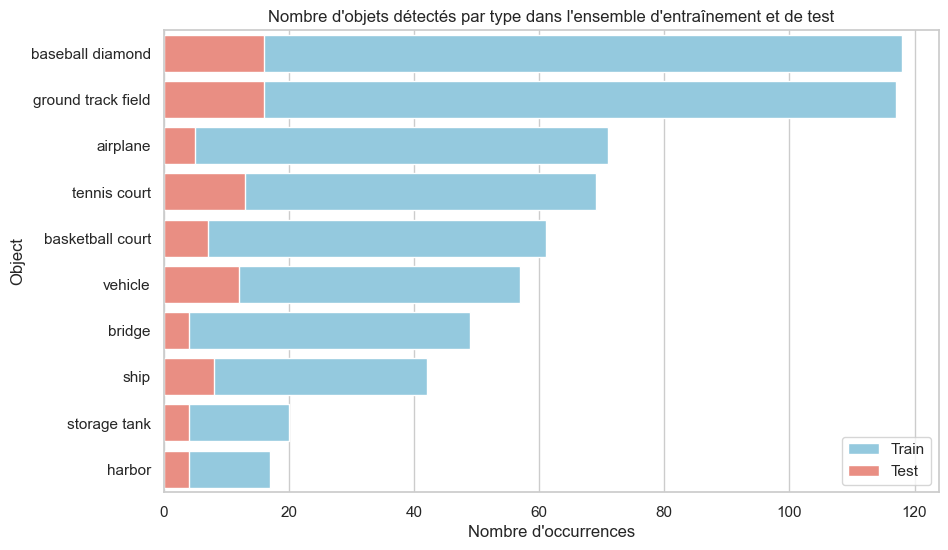

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# Extraire les types d'objets et les nombres d'occurrences pour l'entraînement et le test
objects = list(result_dict_train.keys())
train_counts = list(result_dict_train.values())
test_counts = list(result_dict_test.values())

df_train = pd.DataFrame(result_dict_train.items(), columns=['Object', 'Train Count'])
df_test = pd.DataFrame(result_dict_test.items(), columns=['Object', 'Test Count'])

# Fusionner les deux DataFrames pour faciliter la visualisation
df_combined = pd.merge(df_train, df_test, on='Object')

# Définir le style de Seaborn
sns.set(style="whitegrid")

# Créer le graphique
plt.figure(figsize=(10, 6))
sns.barplot(x='Train Count', y='Object', data=df_combined, color='skyblue', label='Train')
sns.barplot(x='Test Count', y='Object', data=df_combined, color='salmon', label='Test')

# Ajouter des titresa et une légende
plt.xlabel('Nombre d\'occurrences')
plt.title('Nombre d\'objets détectés par type dans l\'ensemble d\'entraînement et de test')
plt.legend()

# Afficher le graphique
plt.show()

In [ ]:
!git clone https://github.com/tomgross/Mask_RCNN.git

In [ ]:
cd Mask_RCNN